In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import multivariate_normal
import math
from numpy.linalg import inv
from numpy import matmul as mm
import scipy
from scipy.linalg import lu_factor,lu_solve
from scipy.linalg import cho_factor,cho_solve
from scipy.stats import multivariate_normal

In [2]:
w1, w2 = np.mgrid[-20:20:1, -20:20:1]
pos = np.dstack((w1, w2))
print(w1.shape, w2.shape)

(40, 40) (40, 40)


In [3]:
w = 7+np.random.randn(1,2)
x = np.array([[-1,3,1]])
x_ = np.vstack((np.array([1,1,1]),x))
n = np.random.randn(1,3)
y = mm(w,x_)+n
print(x,y,w)
print(x.shape,y.shape)
mse = (y-(np.expand_dims(w1,axis=2)+np.expand_dims(w2,axis=2)*x))**2/3
mse = np.sum(mse,axis=2)
print(mse.shape)

[[-1  3  1]] [[ 1.26464533 27.08391098 15.34998099]] [[8.01368457 6.39807477]]
(1, 3) (1, 3)
(40, 40)


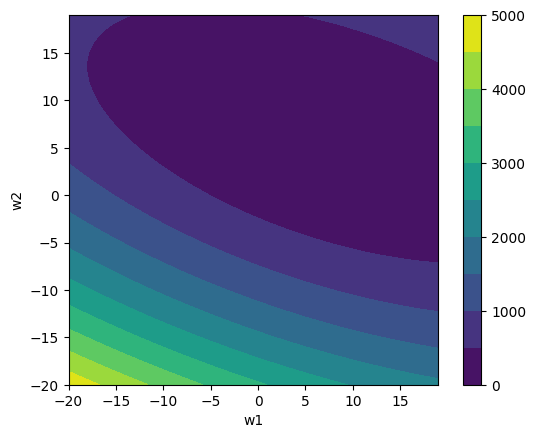

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(w1,w2,mse,10)
ax.set_xlabel('w1')
ax.set_ylabel('w2')
fig.colorbar(cs)
ax.set_aspect(1)

In [5]:
f_lasso = lambda w1,w2: np.abs(w1)+np.abs(w2)
f_ridge = lambda w1,w2: w1**2+w2**2

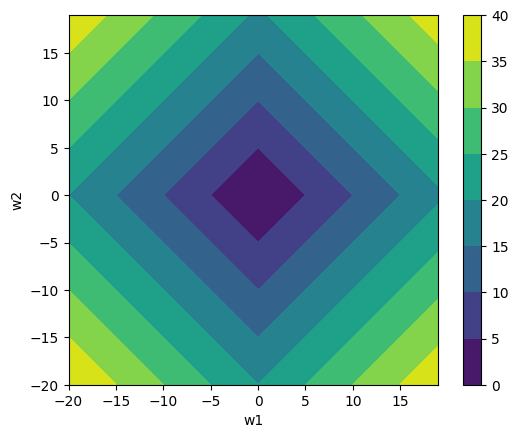

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(w1,w2,f_lasso(w1,w2))
ax.set_xlabel('w1')
ax.set_ylabel('w2')
fig.colorbar(cs)
ax.set_aspect(1)

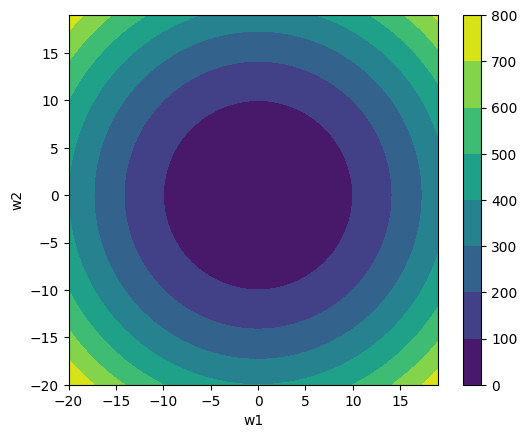

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(w1,w2,f_ridge(w1,w2))
ax.set_xlabel('w1')
ax.set_ylabel('w2')
fig.colorbar(cs)
ax.set_aspect(1)

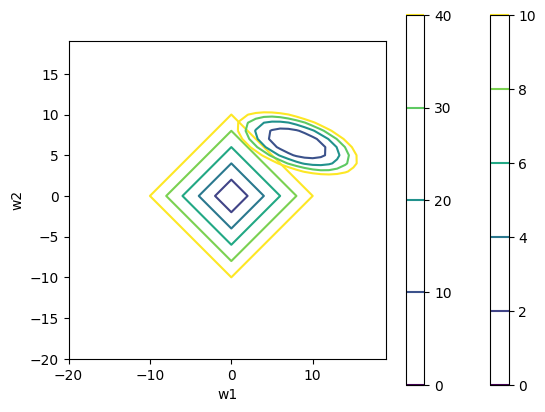

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs1 = ax.contour(w1,w2,f_lasso(w1,w2),[0,2,4,6,8,10])
cs2 = ax.contour(w1,w2,mse,[0,10,20,30,40])
ax.set_xlabel('w1')
ax.set_ylabel('w2')
fig.colorbar(cs1)
fig.colorbar(cs2)
ax.set_aspect(1)

/var/folders/zy/n6_s0nks7mb_rp1whl3wy6k80000gn/T/ipykernel_3796/1074544686.py:6: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(cs)


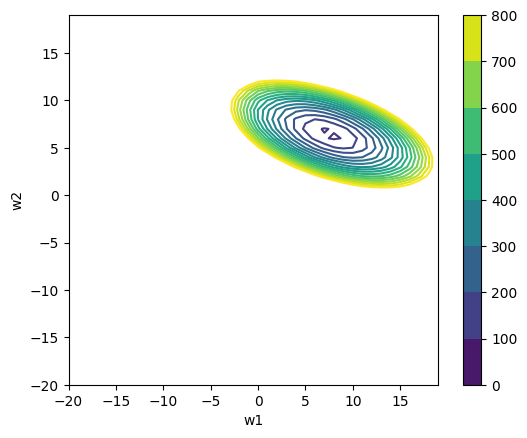

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contour(w1,w2,f_lasso(w1,w2)+mse,np.linspace(0,100,20))
ax.set_xlabel('w1')
ax.set_ylabel('w2')
fig.colorbar(cs)
ax.set_aspect(1)

### Dependent weights? (Maybe not)

In [10]:
var = 4
w = np.array([[0,20]])
x = np.array([[-1,0,2]])
n = var*np.random.randn(1,3)
# y = mm(w,x_)-w[0,0]*x+n
y = mm(w,x_)+n
print(x,y,w)
print(x.shape,y.shape)
w1_ = np.expand_dims(w1,axis=2)
w2_ = np.expand_dims(w2,axis=2)
# mse = (y-(w1_+(-w1_+w2_)*x))**2/3
mse = (y-w1_-w2_*x)**2/3
mse = np.sum(mse,axis=2)
print(mse.shape)

[[-1  0  2]] [[-16.41119065  60.92727422  15.34809294]] [[ 0 20]]
(1, 3) (1, 3)
(40, 40)


Text(0, 0.5, 'y')

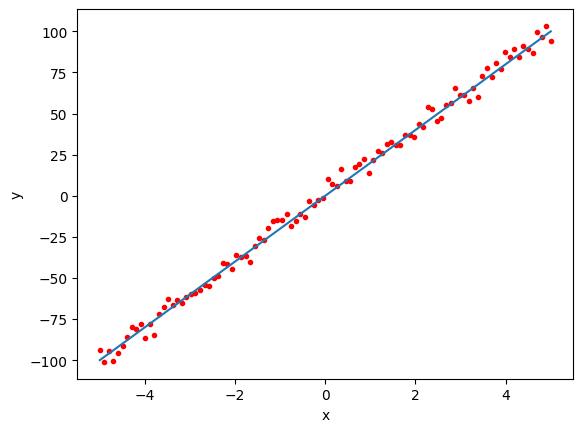

In [11]:
xs = np.linspace(-5,5,100)
# fs = w[0,0]+(-w[0,0]+w[0,1])*xs
fs = w[0,0]+w[0,1]*xs
ys = fs+var*np.random.randn(100)
plt.plot(xs,fs)
plt.scatter(xs,ys,color='red',marker='.')
plt.xlabel('x')
plt.ylabel('y')

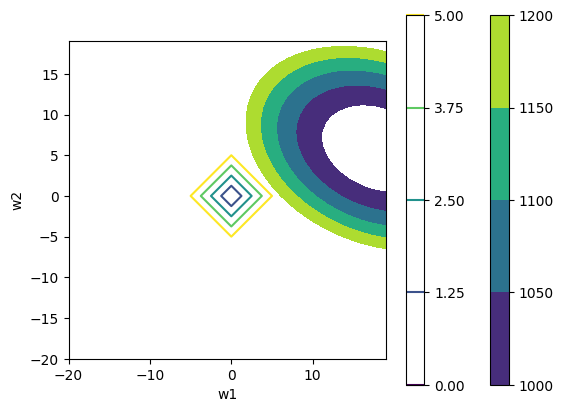

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(w1,w2,mse,np.linspace(1000,1200,5))
cs1 = ax.contour(w1,w2,f_lasso(w1,w2),np.linspace(0,5,5))
ax.set_xlabel('w1')
ax.set_ylabel('w2')
fig.colorbar(cs)
fig.colorbar(cs1)
ax.set_aspect(1)

### Coordinate descent update rule:
Repeat until convergence or max number of iterations:
- For each feature j, 
- Compute $\rho_j=\sum^m_{i=1}x^{(i)}_j(y^{(i)}-\sum^n_{k\neq j}\theta_kx_k^{(i)})$
    - [1x1][1x1]
- Compute $z_j=\sum^m_{i=1}(x^{(i)}_j)^2$
- Set $\theta_j = \frac{1}{z_j}S(\rho_j,\lambda)$
$$\theta_j\begin{cases}
      \frac{\rho_j+\lambda}{z_j} & \text{for $\rho_j < -\lambda$}\\
      0 & \text{for  $ -\lambda \leq\rho_j \leq \lambda$}\\
      \frac{\rho_j-\lambda}{z_j} & \text{for $\rho_j > \lambda$}
    \end{cases}   $$

In [13]:
def opt_l1(lam=2):
    w_init = np.array([[10,2]])
    num_iters = 5
    w_hist = [w_init.copy()]
    for it in range(num_iters):
        for j in range(2):
            xj = x_[np.isin(np.arange(2),j)]
            x_notj = x_[~np.isin(np.arange(2),j)]
            w_init_notj = w_init.T[~np.isin(np.arange(2),j)]
            rhoj = (xj*(y-x_notj*w_init_notj)).sum()
            zj = (xj**2).sum()
            if rhoj<-lam:
                w_init[0,j] = (rhoj+lam)/zj
            elif rhoj>lam:
                w_init[0,j] = (rhoj-lam)/zj
            else:
                w_init[0,j] = 0
        w_hist.append(w_init.copy())

    w_hist = np.vstack(w_hist)
    return w_hist

In [14]:
w_hist2 = opt_l1(.05)
print(w_hist2)

[[10  2]
 [17 14]
 [ 5 18]
 [ 1 19]
 [ 0 19]
 [ 0 19]]


In [15]:
w_hist200 = opt_l1(50)
print(w_hist200)

[[10  2]
 [ 1 14]
 [ 0 14]
 [ 0 14]
 [ 0 14]
 [ 0 14]]


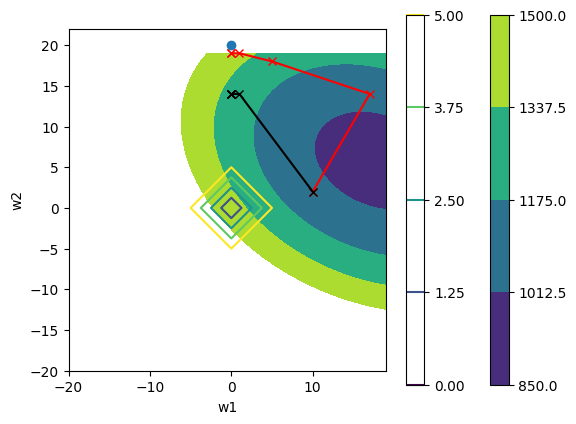

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(w1,w2,mse,np.linspace(850,1500,5))
cs1 = ax.contour(w1,w2,f_lasso(w1,w2),np.linspace(0,5,5))
ax.plot(w_hist2[:,0],w_hist2[:,1],'rx')
ax.plot(w_hist2[:,0],w_hist2[:,1],'r-')
ax.plot(w_hist200[:,0],w_hist200[:,1],'kx')
ax.plot(w_hist200[:,0],w_hist200[:,1],'k-')
ax.scatter(w[0,0],w[0,1])
ax.set_xlabel('w1')
ax.set_ylabel('w2')
fig.colorbar(cs)
fig.colorbar(cs1)
ax.set_aspect(1)

### References
1. https://machinelearningcompass.com/machine_learning_models/lasso_regression/